

## 1번 문제


Basketball.csv 데이터 불러오기

In [113]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Dataminning/data/basketball.csv')
df.head()

,Date,Visitor Team,VisitorPts,Home Team,HomePts,Attend.
0,2015-10-27,Cleveland Cavaliers,95,Chicago Bulls,97,21957
1,2015-10-27,Detroit Pistons,106,Atlanta Hawks,94,19187
2,2015-10-27,New Orleans Pelicans,95,Golden State Warriors,111,19596
3,2015-10-28,Washington Wizards,88,Orlando Magic,87,18846
4,2015-10-28,Philadelphia 76ers,95,Boston Celtics,112,18624


### 해당시즌 우승팀
홈팀에서 이기면 'Home Team'이, 홈팀이 아닌 팀에서 이기면 'Visitor Team'을 갖는 winner라는 새로운 열을 만들었습니다.

In [114]:
df.loc[df['VisitorPts']>df['HomePts'], "winner"] = df["Visitor Team"]
df.loc[df['VisitorPts']<df['HomePts'], "winner"] = df["Home Team"]
df[['winner']].isnull().sum() # 혹시, 비긴 팀이 있을까봐 null값을 확인해주었습니다.

winner    0
dtype: int64

df에 winner열을 OneHotEncoder을 시키고, 각 팀에 대해 합을 구합니다.

In [115]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse = False)

out_enc = enc.fit_transform(df[['winner']])
new_cols = enc.get_feature_names_out(df[['winner']].columns).tolist()

winner_enc = pd.DataFrame(data =out_enc, columns= new_cols) #winner_enc로 onehotencoding한 부분만 새로운 데이터 프레임을 만들어 주었습니다.

winner_enc.sum()

winner_Atlanta Hawks             52.0
winner_Boston Celtics            50.0
winner_Brooklyn Nets             21.0
winner_Charlotte Hornets         51.0
winner_Chicago Bulls             42.0
winner_Cleveland Cavaliers       73.0
winner_Dallas Mavericks          43.0
winner_Denver Nuggets            33.0
winner_Detroit Pistons           44.0
winner_Golden State Warriors     88.0
winner_Houston Rockets           42.0
winner_Indiana Pacers            48.0
winner_Los Angeles Clippers      55.0
winner_Los Angeles Lakers        17.0
winner_Memphis Grizzlies         42.0
winner_Miami Heat                55.0
winner_Milwaukee Bucks           33.0
winner_Minnesota Timberwolves    29.0
winner_New Orleans Pelicans      30.0
winner_New York Knicks           32.0
winner_Oklahoma City Thunder     66.0
winner_Orlando Magic             35.0
winner_Philadelphia 76ers        10.0
winner_Phoenix Suns              23.0
winner_Portland Trail Blazers    49.0
winner_Sacramento Kings          33.0
winner_San A

각 팀에 대한 이름과, 이긴 횟수를 합쳐 데이터 프레임을 만듭니다.

In [116]:
Team = pd.DataFrame(new_cols, columns=['Team'])
number =  pd.DataFrame(data=winner_enc.sum().values,columns=['number'])
winner = pd.concat([Team, number], axis=1)

number에 대해서 내림차순으로 정렬 시켜 첫 번째 행의 첫 번째열 값을 가져왔습니다.

In [117]:
winner=winner.sort_values('number', ascending=False)
seasonwinner = winner.iloc[0,0]
seasonwinner.strip('winner_Golden ')

print("이번 시즌 우승 팀은 "+ seasonwinner.strip('winner_Golden ')+ "입니다.")  # 팀이름 앞에 'winner_Golden '가 붙어 있으므로 제거 해준 후 출력했습니다.

이번 시즌 우승 팀은 State Warriors입니다.


### 홈팀 승패 예측 모델 만들기
홈팀의 승패를 예측하기 위해서 VisitorPts에서 이기면 0으로, HomePts에서 이기면 1로 'winnerPts'라는 타겟을 만들어 주었습니다.

In [118]:
df.loc[df['VisitorPts']>df['HomePts'], "winnerPts"] = 0
df.loc[df['VisitorPts']<df['HomePts'], "winnerPts"] = 1
df.head()

,Date,Visitor Team,VisitorPts,Home Team,HomePts,Attend.,winner,winnerPts
0,2015-10-27,Cleveland Cavaliers,95,Chicago Bulls,97,21957,Chicago Bulls,1.0
1,2015-10-27,Detroit Pistons,106,Atlanta Hawks,94,19187,Detroit Pistons,0.0
2,2015-10-27,New Orleans Pelicans,95,Golden State Warriors,111,19596,Golden State Warriors,1.0
3,2015-10-28,Washington Wizards,88,Orlando Magic,87,18846,Washington Wizards,0.0
4,2015-10-28,Philadelphia 76ers,95,Boston Celtics,112,18624,Boston Celtics,1.0


관객수와 경기 날짜도 홈팀의 승패를 예측하는데에 도움이 될거 같다는 생각을 했습니다.\
그래서 경기 날짜를 OrdinalEncoder을 했고, 상관계수를 비교 해봤습니다.\
경기 날짜에 대한 상관계수는 매우 낮지만, 데이터가 너무 없기 때문에 날짜를 뺀 것보다는 포함 한 것이 f1score가 더 높아 포함하기로 결정했습니다.

In [119]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()

out_enc = enc.fit_transform(df[['Date']])
Date_enc = pd.DataFrame(data =out_enc, columns=['Date'])

Data = pd.concat([Date_enc, df[['Attend.']], df[['winnerPts']]], axis=1)

cor = Data.corr()
cor_target = abs(cor['winnerPts'])
print(cor_target)

X = pd.concat([df[['Attend.']],Date_enc], axis=1)
y =df[['winnerPts']]  #target값

Date         0.028989
Attend.      0.127206
winnerPts    1.000000
Name: winnerPts, dtype: float64


Support Vector Machine, Logistic Regression, DecisionTreeClassifier 중 SVC가 f1 score 높아 이를 선택했습니다.

In [120]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

X_train,X_test,y_train,y_test=\
train_test_split(X, y, test_size=.33, random_state=42)

clf =  SVC(kernel = 'linear', C=1)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
f1 = f1_score(y_test, y_pred)
print("f1 score is = "+str(f1))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


f1 score is = 0.761764705882353


#2번 문제
#### adult 데이터 불러오기.

In [121]:
import pandas as pd
adult = pd.read_csv('/content/drive/MyDrive/Dataminning/data/adult.data', header=None)
adult.columns =['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','Earnings-Raw']
adult.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Earnings-Raw
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


#### Encoding
범주형인 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship','race','sex','native-country','Earnings-Raw' 
이를 모두 OnHotencoding을 하면 데이터 양이 너무 많아져 더 안 좋은 모델이 나왔습니다\
그래서 범주 갯수가 10개보다 작은 것들은 Onhotencoding을, 10개보다 큰 것은 OrdinalEncoding, target값인 Earning-Raw는 LabelEncoder을 선택했습니다.

In [122]:
X1 = adult[['workclass','marital-status','relationship','race','sex']]  # OnHotencoding 할 부분 
X2 = adult[['education','occupation','native-country']]                 # OrdinalEncoding 할 부분
X3 = adult[['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']] # 연속형 변수
y = adult ['Earnings-Raw']  # LabelEncoding 할 부분

#OneHotEncoder

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse = False)

out_enc = enc.fit_transform(X1)
new_cols = enc.get_feature_names_out(X1.columns).tolist()

X1_enc = pd.DataFrame(data =out_enc, columns= new_cols)


In [123]:
# OrdinalEncoder

from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()

out_enc = enc.fit_transform(X2)
X2_enc = pd.DataFrame(data =out_enc, columns=['education','occupation','native-country'])

In [124]:
# LabelEncoder

from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
out_enc = enc.fit_transform(y)
y_enc = pd.DataFrame(data = out_enc, columns = ['Earnings-Raw'])

# 인코딩한 데이터와 연속형 변수 하나의 데이터 프레임으로 만들기.
Data = pd.concat([X1_enc,X2_enc,X3,y_enc], axis=1)

#### 상관계수 기반 특징 선택

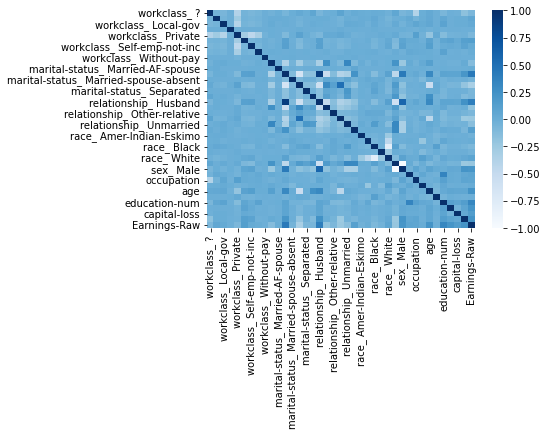

In [125]:
cor = Data.corr()
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cor, annot=False, cmap=plt.cm.Blues)
plt.show()

In [126]:
# target과의 상관관계 보기

cor_target = abs(cor['Earnings-Raw'])
print(cor_target)

workclass_ ?                             0.078198
workclass_ Federal-gov                   0.059372
workclass_ Local-gov                     0.033091
workclass_ Never-worked                  0.008259
workclass_ Private                       0.078528
workclass_ Self-emp-inc                  0.139467
workclass_ Self-emp-not-inc              0.030019
workclass_ State-gov                     0.014843
workclass_ Without-pay                   0.011681
marital-status_ Divorced                 0.126995
marital-status_ Married-AF-spouse        0.012061
marital-status_ Married-civ-spouse       0.444696
marital-status_ Married-spouse-absent    0.042532
marital-status_ Never-married            0.318440
marital-status_ Separated                0.074386
marital-status_ Widowed                  0.064381
relationship_ Husband                    0.401035
relationship_ Not-in-family              0.188497
relationship_ Other-relative             0.083716
relationship_ Own-child                  0.228532


target과의 상관관계가 매우 낮아 0.2를 기준으로 잡았습니다.

In [127]:
selected_cols = cor_target[cor_target > 0.2]
print("selected column, correlation")
print(selected_cols)

df_sel = Data[selected_cols.index] # 상관계수가 0.2보다 높은 부분 데이터 프레임 생성
print(df_sel.head())

selected column, correlation
marital-status_ Married-civ-spouse    0.444696
marital-status_ Never-married         0.318440
relationship_ Husband                 0.401035
relationship_ Own-child               0.228532
sex_ Female                           0.215980
sex_ Male                             0.215980
age                                   0.234037
education-num                         0.335154
capital-gain                          0.223329
hours-per-week                        0.229689
Earnings-Raw                          1.000000
Name: Earnings-Raw, dtype: float64
   marital-status_ Married-civ-spouse  marital-status_ Never-married  \
0                                 0.0                            1.0   
1                                 1.0                            0.0   
2                                 0.0                            0.0   
3                                 1.0                            0.0   
4                                 1.0                      

#### GridSearch

DecisionTreeClassifier을 GridSeach했을 때 가장 높은 f1 scroe가 나와 이 방법을 택했습니다.

In [128]:
from sklearn.model_selection import train_test_split

X=df_sel.iloc[:,:-1]
y=df_sel['Earnings-Raw']
X.head()

X_train,X_test,y_train,y_test=\
train_test_split(X,y, test_size=.33, random_state=42)

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

param = {
    "min_samples_leaf":[1,2,3,4,5,6,7,8,9],
    "max_depth":[2,3,4,5,6,None],
    "min_samples_split":[2,3,4,5,6,7,8,9,10]
}
df = DecisionTreeClassifier()
clf = GridSearchCV(df, param_grid=param, cv=5, refit=True)

clf.fit(X_train,y_train)

print('Best score is = ', str(clf.best_score_))
print('Best parameters are = ',str(clf.best_params_))

Best score is =  0.8465734586293834
Best parameters are =  {'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 5}


In [130]:
from sklearn import metrics

y_pred = clf.predict(X_test)
f1 = metrics.f1_score(y_test, y_pred, average='macro')
print("f1 score is = "+str(f1))

f1 score is = 0.7577376674979921
